In [1]:
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import jax
from jax import random, numpy as jnp
import flax.linen as nn

In [2]:
from visturing.properties.jax import prop1

In [3]:
data_path = "../Data/Experiment_1"
gt_path = "../Data/ground_truth"

In [4]:
class Model(nn.Module):
    @nn.compact
    def __call__(self, inputs):
        b, h, w, c = inputs.shape
        return nn.Conv(features=c, kernel_size=1, use_bias=False)(inputs)

In [5]:
model = Model()
variables = model.init(random.PRNGKey(42), jnp.ones((1,256,256,3)))
params = variables["params"]
params

{'Conv_0': {'kernel': Array([[[ 0.26978174, -0.314012  ,  0.89799595],
          [ 0.00569335,  0.13840543, -0.9635549 ],
          [-0.33585423,  0.8945437 , -0.97497624]]], dtype=float32)}}

In [6]:
def calculate_diffs(img1, img2):
    output_a = model.apply({"params": params}, img1)
    output_b = model.apply({"params": params}, img2)
    return ((output_a - output_b)**2).mean(axis=(1,2,3))**(1/2)

In [7]:
results = prop1.evaluate(calculate_diffs,
            data_path=data_path,
            gt_path=gt_path)

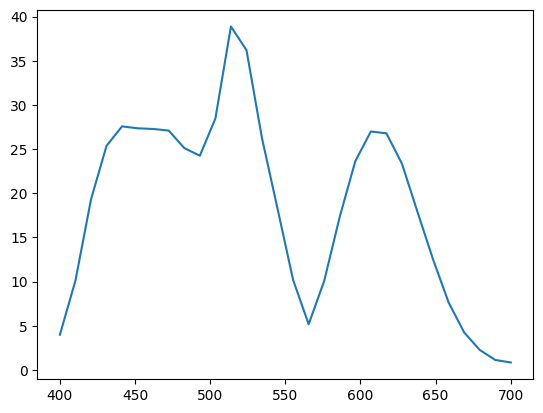

In [8]:
plt.plot(results["lambdas"], results["diffs"])
plt.show()

In [9]:
@jax.jit
def step(params, lr=0.01):
    def loss_fn(params):
        def calculate_diffs(img1, img2):
            output_a = model.apply({"params": params}, img1)
            output_b = model.apply({"params": params}, img2)
            return ((output_a - output_b)**2).mean(axis=(1,2,3))**(1/2)

        results = prop1.evaluate(calculate_diffs,
                    data_path=data_path,
                    gt_path=gt_path)
        return -results["correlations"]["pearson"]
    loss, grad = jax.value_and_grad(loss_fn)(params)
    params = jax.tree_util.tree_map(lambda x, g: x-g*lr, params, grad)
    return params, loss, grad

In [10]:
EPOCHS = 1000
lr = 0.01
losses, grads = [], []
for epoch in tqdm(range(EPOCHS)):
    params, loss, grad = step(params)
    losses.append(loss)
    grads.append(grad)

  0%|          | 0/1000 [00:00<?, ?it/s]

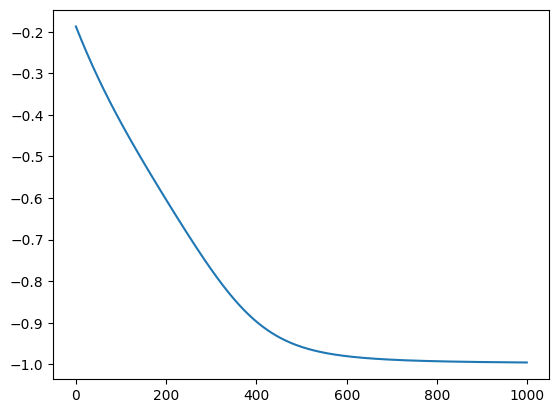

In [11]:
plt.plot(losses)
plt.show()

In [12]:
def calculate_diffs(img1, img2):
    output_a = model.apply({"params": params}, img1)
    output_b = model.apply({"params": params}, img2)
    return ((output_a - output_b)**2).mean(axis=(1,2,3))**(1/2)

In [13]:
results = prop1.evaluate(calculate_diffs,
            data_path=data_path,
            gt_path=gt_path)

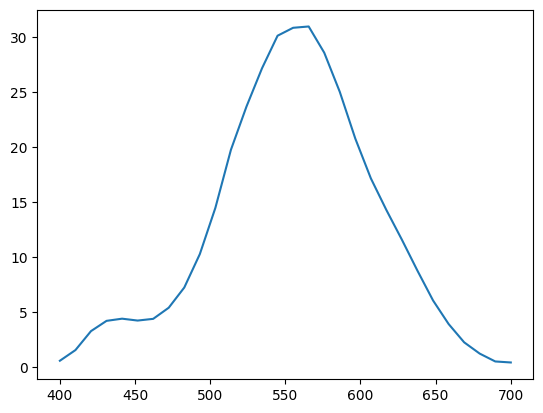

In [14]:
plt.plot(results["lambdas"], results["diffs"])
plt.show()